In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])#,transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [3]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000,shuffle=True)

print len(train_loader), len(test_loader)

ip_dim = 28*28
z_dim = 2
comb_dim = ip_dim + z_dim

600 10


### Check tsne

In [4]:
# xtmp,label_tmp = next(iter(test_loader))
# xtmp = xtmp.numpy()
# xtmp = xtmp.reshape(1000,28*28)
# X_embedded = TSNE(n_components=2).fit_transform(xtmp)
# plt.figure(figsize=(8, 6)) 
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c = labels2,cmap=plt.cm.hot)
# plt.colorbar()
# plt.grid()
# plt.show()  

In [5]:
#### Encoder

class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,300)
        self.l4 = nn.Linear(300,300)
        self.l5 = nn.Linear(300,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = (self.l5(x))
        
        return x

### Decoder

class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim+10,300)
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,500)
        self.l4 = nn.Linear(500,500)
        self.l5 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.leaky_relu(self.l4(x))
        x = F.sigmoid(self.l5(x))
        
        return x

###  Discriminator

class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(z_dim+10,100)
        self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x
    
class disc2(nn.Module):
    def __init__(self):
        super(disc2,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,100)
        self.l4 = nn.Linear(100,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x

In [6]:
def add_label_info(y,batch_size,numpy=False):

    tmp = np.zeros((batch_size,10))
    if(numpy == False):
        y = y.cpu().numpy().reshape(batch_size,1)
    for i in range(y.shape[0]):
        tmp[i,y[i]] = 5
    label_info = torch.from_numpy((tmp))
    return label_info

In [7]:
def get_true_z(mean_z,label):
    
    noise = np.random.randn(batch_size,z_dim)
    label = label.numpy().reshape(batch_size,1)
    #print noise.shape,label.shape
    #z = 0.1*noise + label*10
    
    z = 0.1*noise + mean_z[label]
    z = Variable(torch.FloatTensor(z))
    return z
    #z = torch.add(noise,value=1,other=label)
    #z = Variable(z.cuda())

In [8]:
def train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering,mean_z = mean_z):
    recon = []
    encode = []
    discriminate = []
    for it in range(2,1000):
        x,y = next(iter(train_loader))
       
        x = x.view(batch_size,28*28)
        if(cuda==True):
            x = Variable(x.cuda())
            label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor)).cuda()

        else:
            x = Variable(x)
            label_info = Variable((add_label_info(y,batch_size)).type(torch.FloatTensor))

        z = Q(x)

        #Reconstruction

        z_false = (torch.cat([z,label_info],1))
        
        x_recon = P(z_false)
        
        add_small = 1e-20
        
        if(it%1==0):
            CEL = F.binary_cross_entropy(x_recon,x)
            #CEL = criterion(x_recon, x)
        
            CEL.backward(retain_graph=True)
            Q_solver.step()
            P_solver.step()
        
            Q.zero_grad()
            P.zero_grad()
        #recon.append(CEL)

# ## use a discriminator to learn the reconstruction loss also discriminatively
#         if(it%2==0):
#             Dx_false = D2(x_recon)
#             Dx_true = D2(x)
            
#             D2_loss = -torch.mean(torch.log(Dx_true + add_small) + torch.log(1 - Dx_false + add_small))
#             D2_loss.backward(retain_graph=True)
#             D2_solver.step()
#             D2.zero_grad()
        
#             Dx_false = D2(x_recon)
            
#             recon_loss = -torch.mean(torch.log(Dx_false)) + 0.5*F.binary_cross_entropy(x_recon,x)
#             recon_loss.backward(retain_graph=True)
#             Q_solver.step()
#             P_solver.step()
#             Q.zero_grad()
#             P.zero_grad()
            
        

        
        
        
        
        
        #Discriminator
       
        z_true = Variable(torch.randn(batch_size,z_dim).cuda())
        if cuda==True:
            if clustering is True:
                z_true = get_true_z(mean_z,y).cuda()
            else:
                z_true = Variable(torch.cat([z_true,label_info],1).data).cuda()
        else:
            if clustering is True:
                z_true = get_true_z(mean_z,y)
            else:
                z_true = Variable(torch.cat([z_true,label_info],1).data)

        z_true_op = D(z_true)
        
        z_false_op = D(z_false)
        
        
        if(it%1==0):
    
            loss_d = -torch.mean(torch.log(z_true_op + add_small) + torch.log(1 - z_false_op + add_small))
            loss_d.backward(retain_graph=True)
            D_solver.step()
            D.zero_grad()
            discriminate.append(loss_d)

    #Updating the encoder
        G_loss = -torch.mean(torch.log(z_false_op+1e-20))
        G_loss.backward(retain_graph=True)
        Q_solver.step()
        Q_solver.zero_grad()
        encode.append(G_loss)
        
        
    ## occasionally update the encoder with MSE loss
    
#         if(it%25==0):
#             tmp_loss = nn.MSELoss()(z_false,z_true)
#             print('tmp_loss:',tmp_loss.data[0])
#             tmp_loss = 1e-3*tmp_loss
#             tmp_loss.backward()
#             Q_solver.step()
#             Q_solver.zero_grad()

        
        
        if(it%25==0):
            #print(extra_loss.data[0],CEL.data[0])
            print('recon_loss:', CEL.data[0],'disc_loss:', loss_d.data[0])
            print('gen_loss: ',G_loss.data[0])#,'D2_loss',D2_loss.data[0])
#             plt.plot(range(1,it),np.array(discriminate).reshape(len(discriminate),1))
#             plt.title('discriminator loss')
#             plot.show()
            
            
#             plt.plot(range(1,it),np.array(encode).reshape(len(encode),1))
#             plt.title('encoder loss')
#             plot.show()
           
#             plt.plot(range(1,it),np.array(reconstruct).reshape(len(reconstruct),1))
#             plt.title('reconstruction loss')
#             plot.show()            
        
        ## plot the distribution ##
        if(it%25 == 0):
            xcheck,labels = next(iter(test_loader))
            xcheck = xcheck.view(1000,28*28)
            xcheck = Variable(xcheck.cuda())
            labels_sc = labels.cpu().numpy()
            #xcheck = Variable(xcheck.view(1000,28*28).cuda())
            zhat = Q(xcheck)
            z_mu = zhat.cpu().data.numpy()
            plt.figure(figsize=(8, 6)) 
           
            plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels_sc)#,cmap=plt.cm.autumn)
            plt.colorbar()
            plt.grid()
            plt.show()   
            
            zcheck = Variable(torch.randn(1,z_dim).cuda())
            
            y = np.array([2])
            label_info = (add_label_info(y,1,numpy=True))
            z_false = np.concatenate((zcheck.cpu().data.numpy(),label_info.cpu().numpy()),1)
            z_false = Variable(torch.FloatTensor(z_false)).cuda()
            print z_false.size()
            x_recon = P(z_false)
            op = x_recon.cpu().data.numpy()
            op = op.reshape(28,28)
            plt.imshow(op)
            plt.show()
    return Q,P

In [9]:
def generate_model(clustering = clustering,mean_z = mean_z):
    
    if cuda==True:
        Q = encoder().cuda()
        P = decoder().cuda()
        D = disc().cuda()
        D2 = disc2().cuda()
    else:
        Q = encoder()
        P = decoder()
        D = disc()
   
    Q_solver = optim.Adam(Q.parameters(),lr=1e-3)
    E_solver = optim.Adam(Q.parameters(),lr = 1e-3)
    
    P_solver = optim.Adam(P.parameters(),lr = 1e-3)
   
    D_solver = optim.Adam(D.parameters(),lr = 1e-3)
    D2_solver = optim.Adam(D2.parameters(),lr = 1e-3)
    Q,P = train_model(Q,Q_solver,P,P_solver,D,D_solver,D2,D2_solver,batch_size,clustering = clustering)
    
 
    
    return Q,P

('recon_loss:', 0.2672559916973114, 'disc_loss:', 1.425318956375122)
('gen_loss: ', 0.42992812395095825)


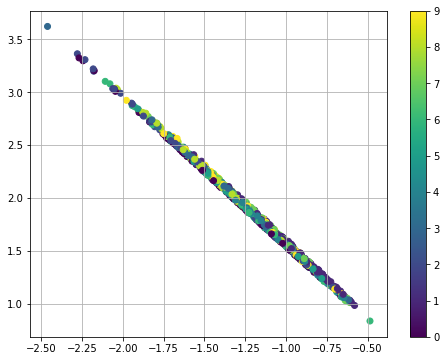

torch.Size([1, 12])


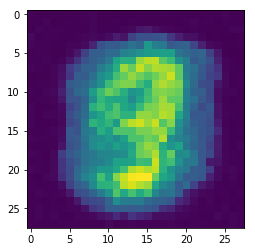

('recon_loss:', 0.2522788643836975, 'disc_loss:', 0.7343528270721436)
('gen_loss: ', 0.6672732830047607)


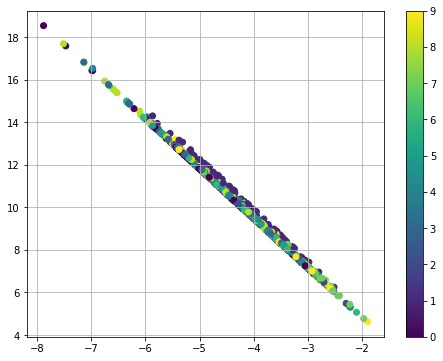

torch.Size([1, 12])


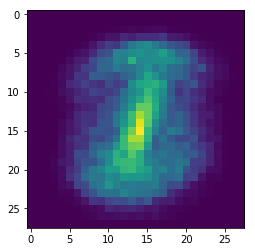

('recon_loss:', 0.22322681546211243, 'disc_loss:', 0.7076478004455566)
('gen_loss: ', 0.679492175579071)


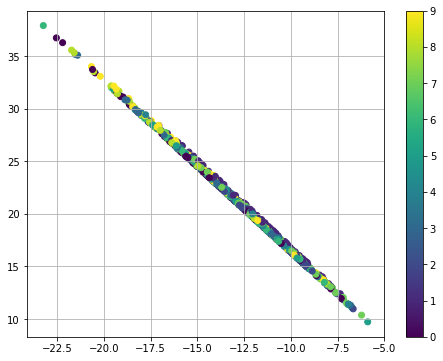

torch.Size([1, 12])


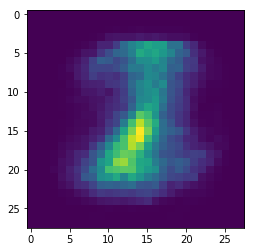

('recon_loss:', 0.23057809472084045, 'disc_loss:', 0.6835517287254333)
('gen_loss: ', 0.7036689519882202)


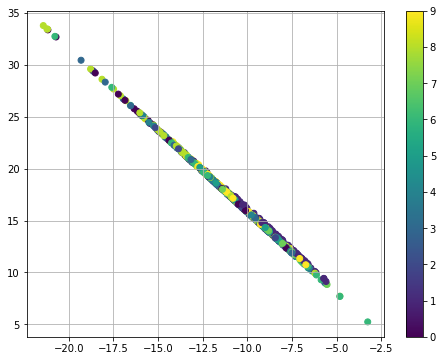

torch.Size([1, 12])


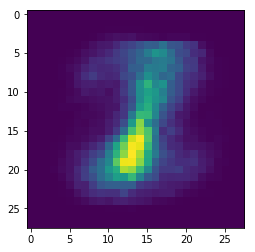

('recon_loss:', 0.2082761526107788, 'disc_loss:', 0.7020277380943298)
('gen_loss: ', 0.6851301789283752)


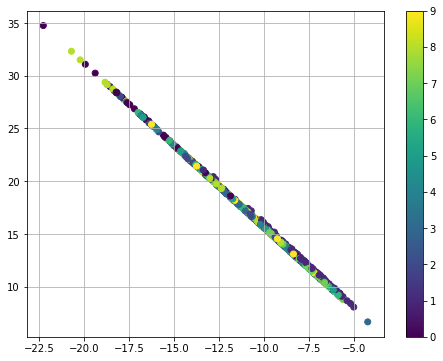

torch.Size([1, 12])


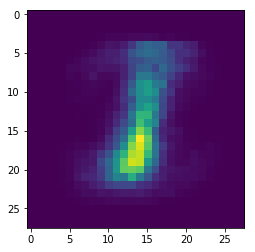

('recon_loss:', 0.20797346532344818, 'disc_loss:', 0.7039533257484436)
('gen_loss: ', 0.6829291582107544)


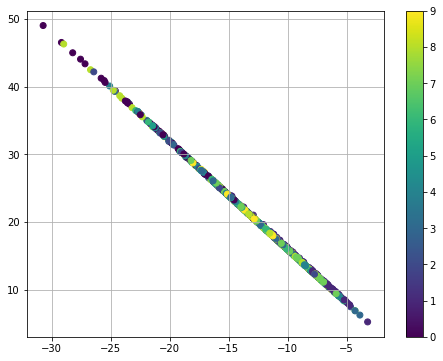

torch.Size([1, 12])


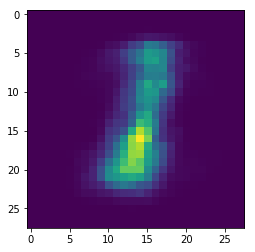

('recon_loss:', 0.21904045343399048, 'disc_loss:', 0.6995394229888916)
('gen_loss: ', 0.6871669888496399)


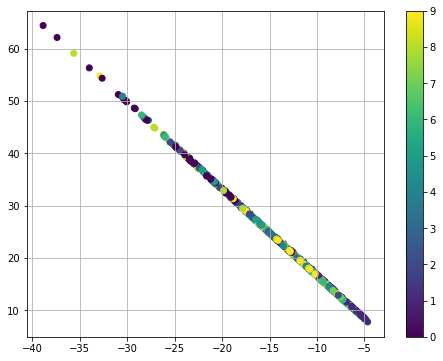

torch.Size([1, 12])


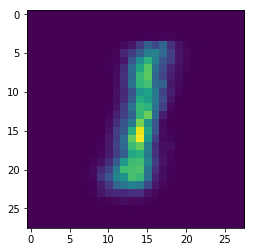

('recon_loss:', 0.2001752108335495, 'disc_loss:', 0.7127727270126343)
('gen_loss: ', 0.6743159294128418)


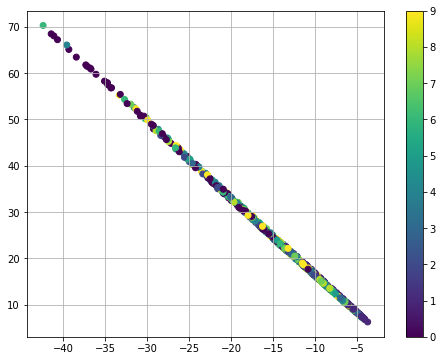

torch.Size([1, 12])


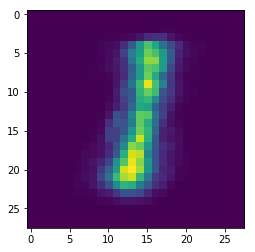

('recon_loss:', 0.19904668629169464, 'disc_loss:', 0.71149080991745)
('gen_loss: ', 0.6753033995628357)


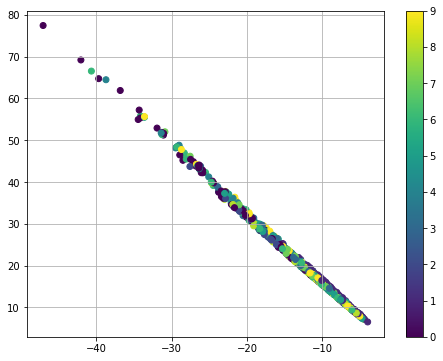

torch.Size([1, 12])


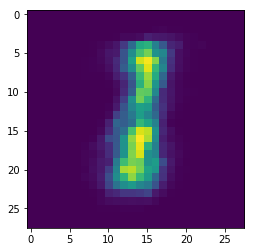

('recon_loss:', 0.20415116846561432, 'disc_loss:', 0.6882479190826416)
('gen_loss: ', 0.6983006000518799)


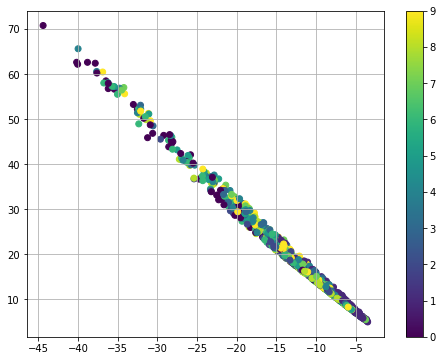

torch.Size([1, 12])


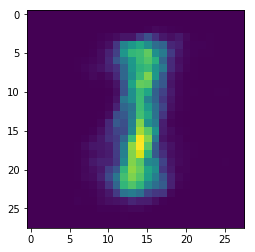

('recon_loss:', 0.204568013548851, 'disc_loss:', 0.7005743980407715)
('gen_loss: ', 0.6860297322273254)


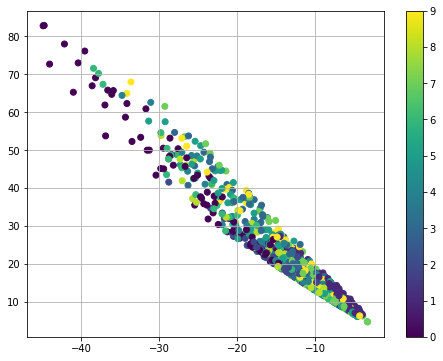

torch.Size([1, 12])


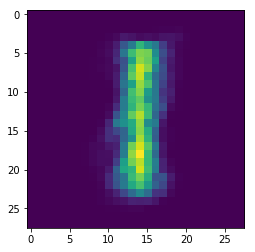

('recon_loss:', 0.19883151352405548, 'disc_loss:', 0.7010136246681213)
('gen_loss: ', 0.6856522560119629)


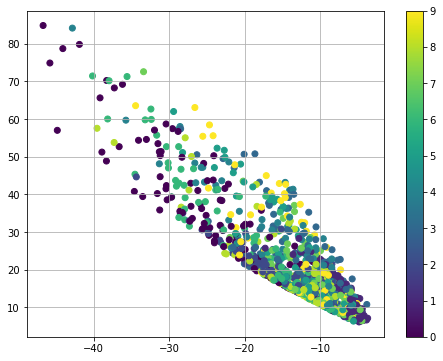

torch.Size([1, 12])


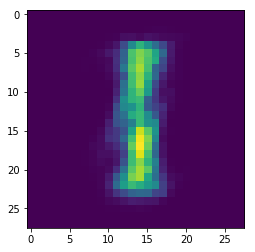

('recon_loss:', 0.1907823234796524, 'disc_loss:', 0.6914141774177551)
('gen_loss: ', 0.6951329112052917)


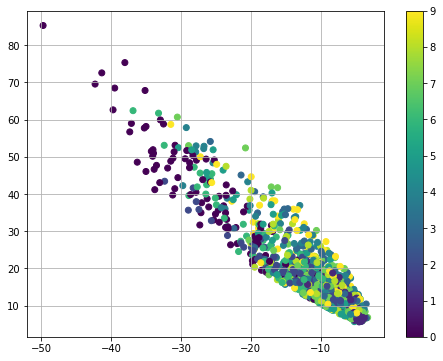

torch.Size([1, 12])


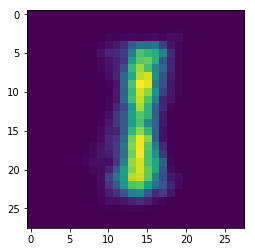

('recon_loss:', 0.18426565825939178, 'disc_loss:', 0.7058355212211609)
('gen_loss: ', 0.6809612512588501)


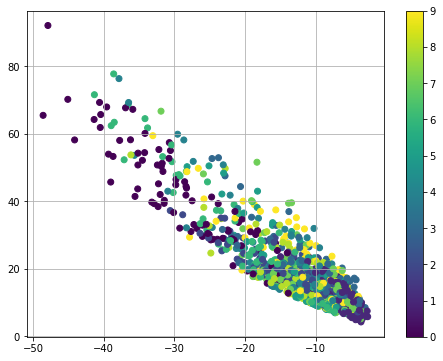

torch.Size([1, 12])


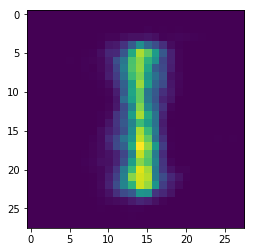

('recon_loss:', 0.1773764044046402, 'disc_loss:', 0.7158428430557251)
('gen_loss: ', 0.6712878942489624)


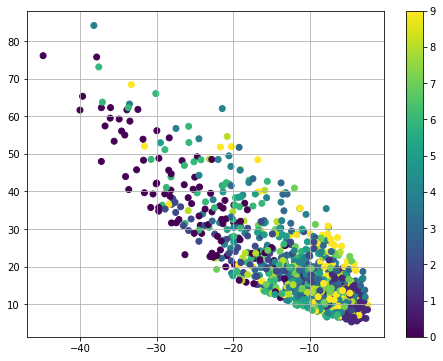

torch.Size([1, 12])


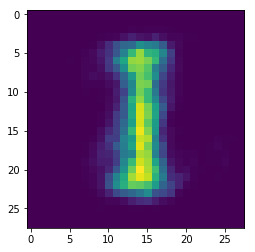

('recon_loss:', 0.18949559330940247, 'disc_loss:', 0.6956028938293457)
('gen_loss: ', 0.6908831000328064)


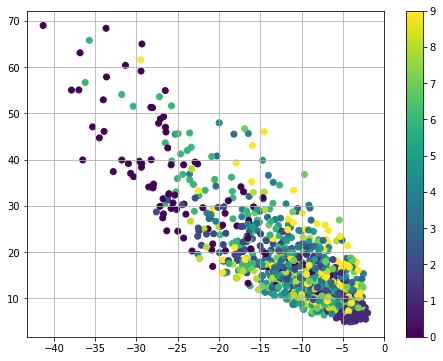

torch.Size([1, 12])


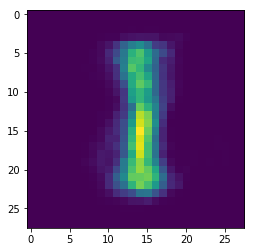

('recon_loss:', 0.17302536964416504, 'disc_loss:', 0.686484158039093)
('gen_loss: ', 0.7004362344741821)


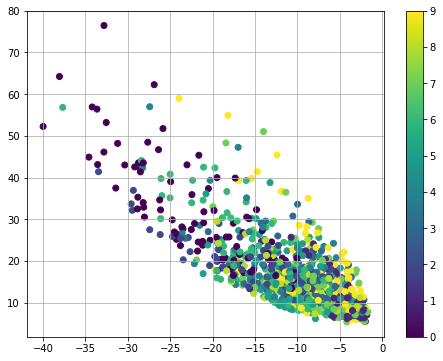

torch.Size([1, 12])


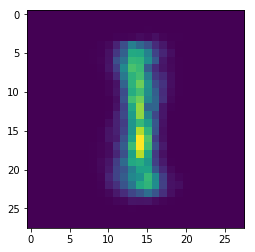

('recon_loss:', 0.1717379242181778, 'disc_loss:', 0.6828572750091553)
('gen_loss: ', 0.7038753032684326)


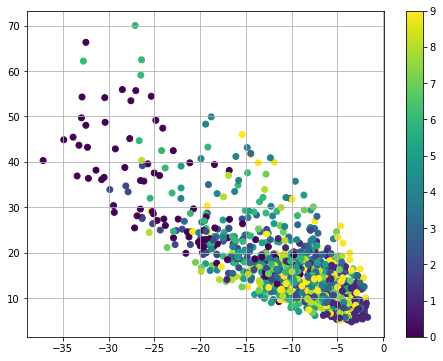

torch.Size([1, 12])


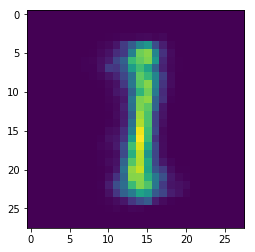

('recon_loss:', 0.17603625357151031, 'disc_loss:', 0.6846741437911987)
('gen_loss: ', 0.7019362449645996)


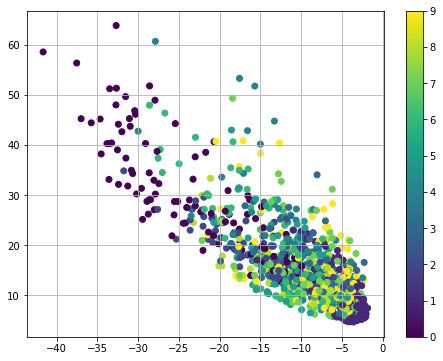

torch.Size([1, 12])


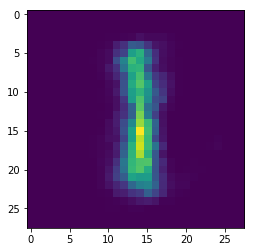

('recon_loss:', 0.17738759517669678, 'disc_loss:', 0.7041076421737671)
('gen_loss: ', 0.6826575994491577)


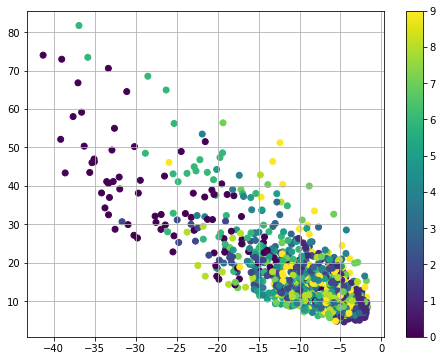

torch.Size([1, 12])


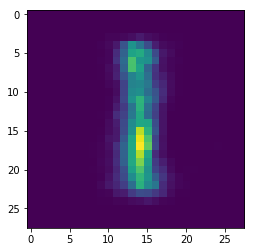

('recon_loss:', 0.18537017703056335, 'disc_loss:', 0.7004260420799255)
('gen_loss: ', 0.6862700581550598)


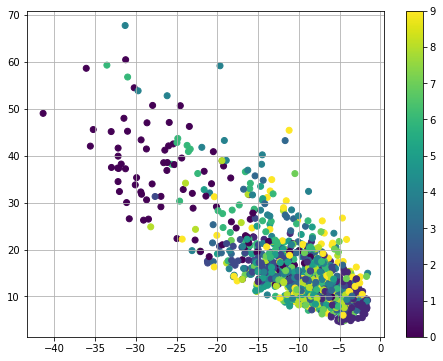

torch.Size([1, 12])


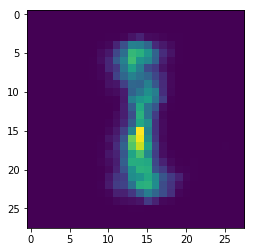

('recon_loss:', 0.17067424952983856, 'disc_loss:', 0.6597225666046143)
('gen_loss: ', 0.7283550500869751)


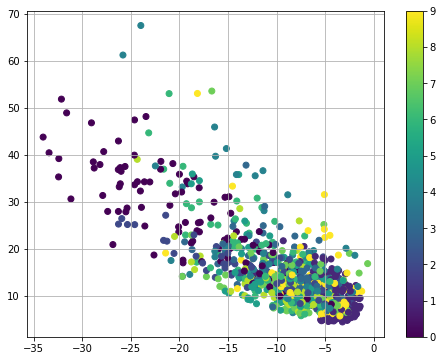

torch.Size([1, 12])


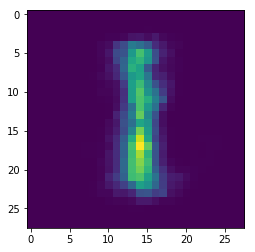

('recon_loss:', 0.17545318603515625, 'disc_loss:', 0.6742573380470276)
('gen_loss: ', 0.7126338481903076)


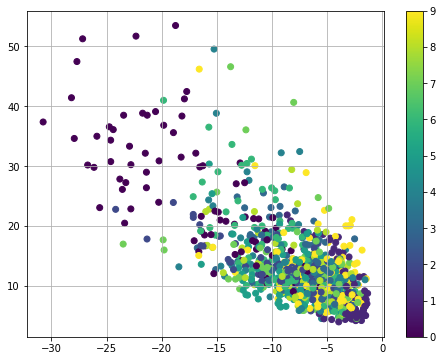

torch.Size([1, 12])


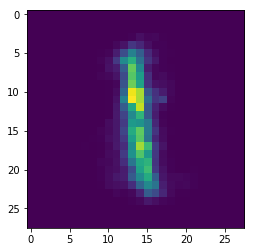

('recon_loss:', 0.17105332016944885, 'disc_loss:', 0.6938166618347168)
('gen_loss: ', 0.6926147937774658)


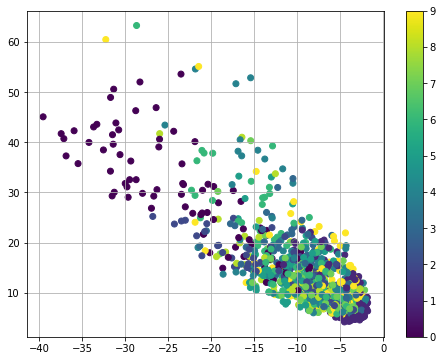

torch.Size([1, 12])


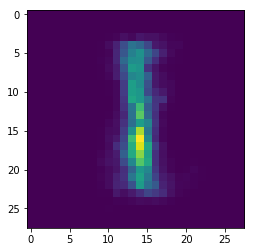

('recon_loss:', 0.15823550522327423, 'disc_loss:', 0.7091163396835327)
('gen_loss: ', 0.6777069568634033)


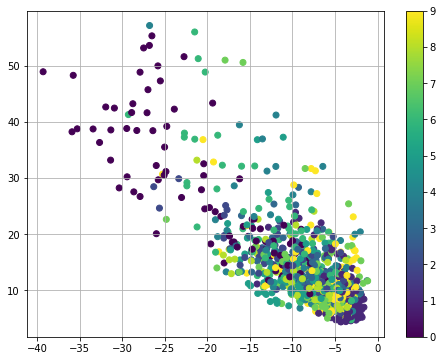

torch.Size([1, 12])


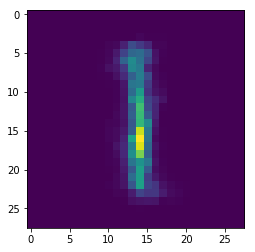

('recon_loss:', 0.1774202585220337, 'disc_loss:', 0.6869866251945496)
('gen_loss: ', 0.6994629502296448)


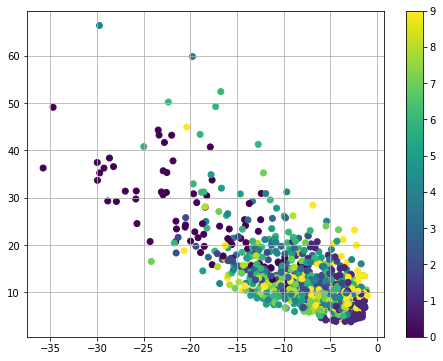

torch.Size([1, 12])


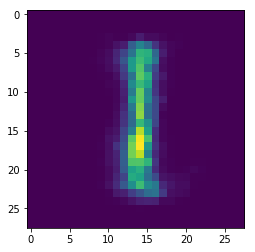

('recon_loss:', 0.15635445713996887, 'disc_loss:', 0.6949619054794312)
('gen_loss: ', 0.6914428472518921)


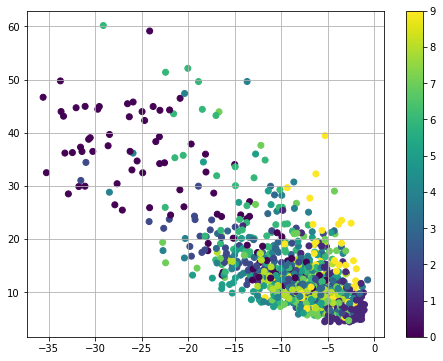

torch.Size([1, 12])


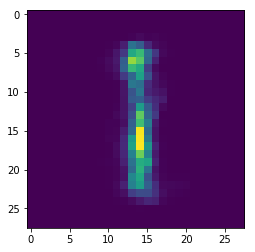

('recon_loss:', 0.17676477134227753, 'disc_loss:', 0.6954576969146729)
('gen_loss: ', 0.6909012794494629)


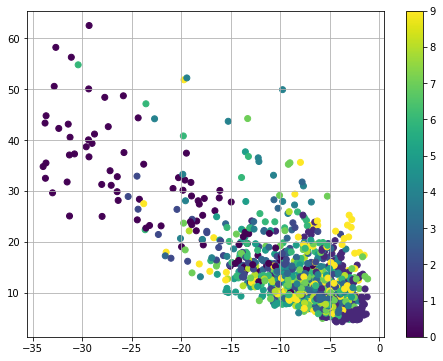

torch.Size([1, 12])


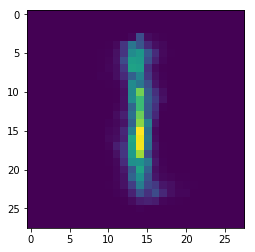

('recon_loss:', 0.17741549015045166, 'disc_loss:', 0.6991584300994873)
('gen_loss: ', 0.6872203946113586)


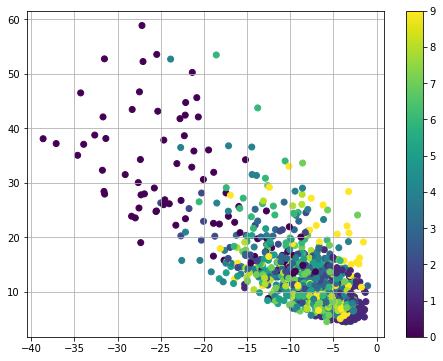

torch.Size([1, 12])


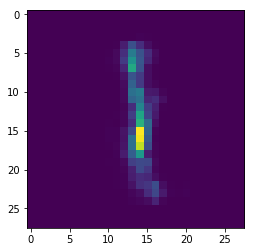

('recon_loss:', 0.1702450066804886, 'disc_loss:', 0.6932089328765869)
('gen_loss: ', 0.6932454109191895)


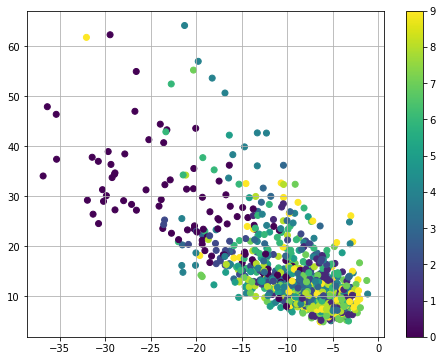

torch.Size([1, 12])


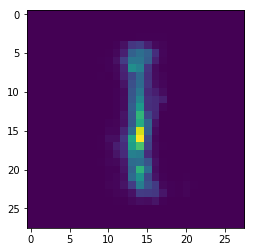

('recon_loss:', 0.17593660950660706, 'disc_loss:', 0.685322105884552)
('gen_loss: ', 0.7012045383453369)


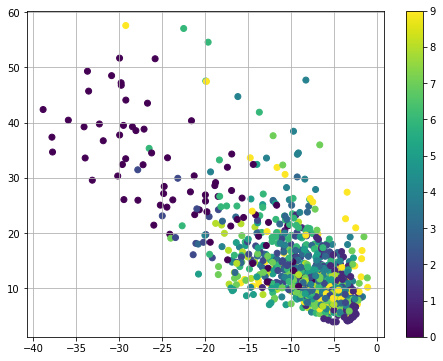

torch.Size([1, 12])


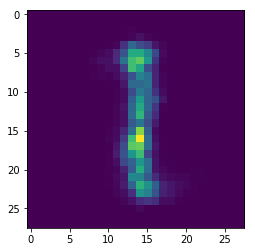

('recon_loss:', 0.1682957112789154, 'disc_loss:', 0.6998544931411743)
('gen_loss: ', 0.6866303086280823)


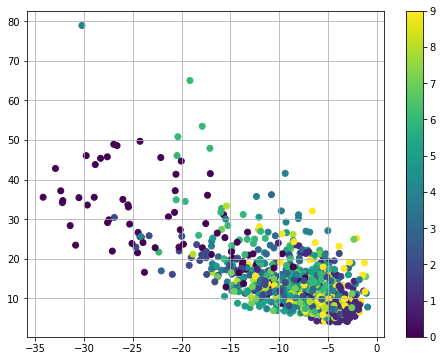

torch.Size([1, 12])


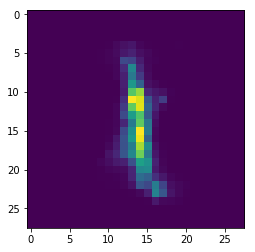

('recon_loss:', 0.16618618369102478, 'disc_loss:', 0.6834523677825928)
('gen_loss: ', 0.7031280398368835)


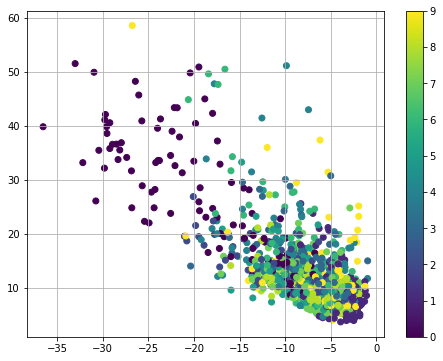

torch.Size([1, 12])


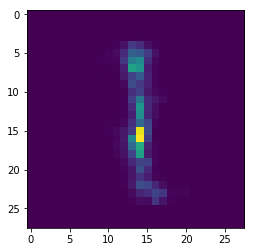

('recon_loss:', 0.1638648957014084, 'disc_loss:', 0.6996185183525085)
('gen_loss: ', 0.6867894530296326)


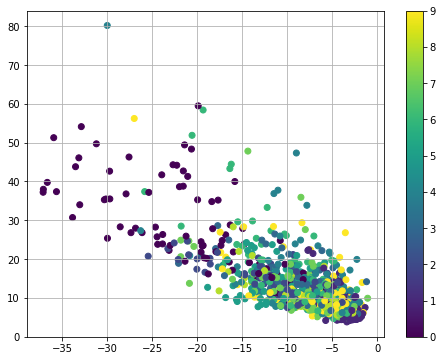

torch.Size([1, 12])


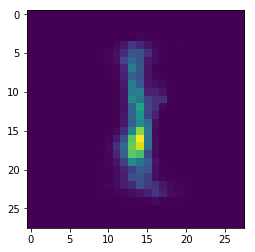

('recon_loss:', 0.17089657485485077, 'disc_loss:', 0.6848868727684021)
('gen_loss: ', 0.701528012752533)


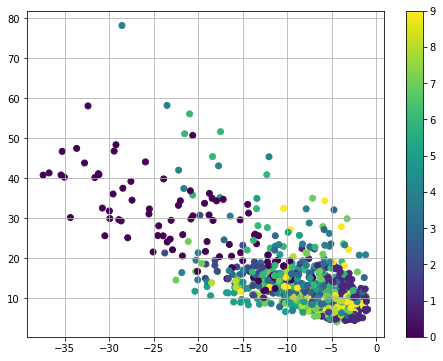

torch.Size([1, 12])


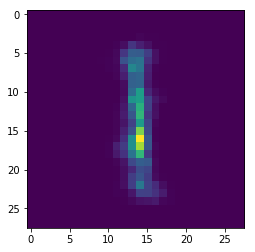

('recon_loss:', 0.1796853095293045, 'disc_loss:', 0.7052116394042969)
('gen_loss: ', 0.6813070178031921)


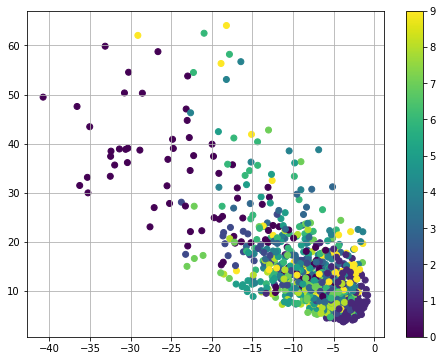

torch.Size([1, 12])


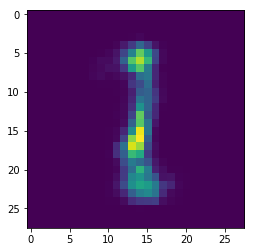

('recon_loss:', 0.17093561589717865, 'disc_loss:', 0.6949549913406372)
('gen_loss: ', 0.6913697123527527)


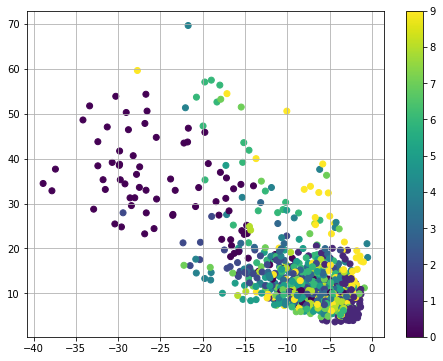

torch.Size([1, 12])


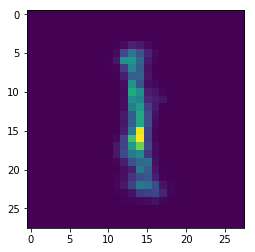

('recon_loss:', 0.16487166285514832, 'disc_loss:', 0.6898996233940125)
('gen_loss: ', 0.6964941620826721)


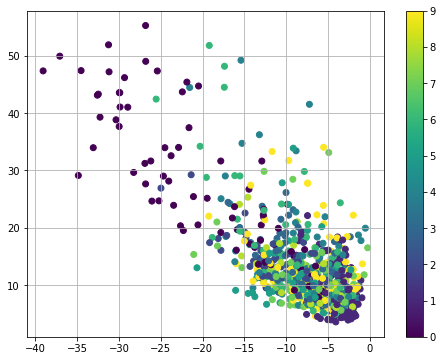

torch.Size([1, 12])


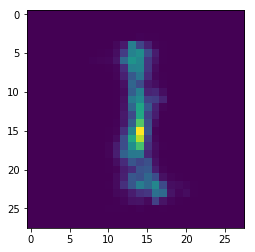

('recon_loss:', 0.16405251622200012, 'disc_loss:', 0.6787870526313782)
('gen_loss: ', 0.7077844738960266)


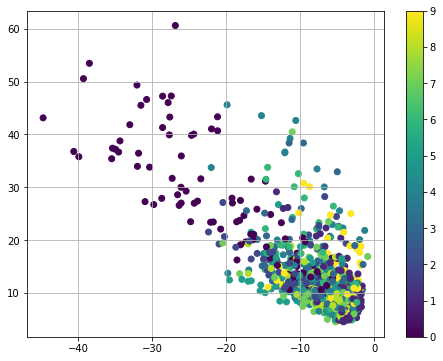

torch.Size([1, 12])


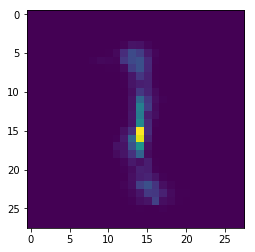

In [10]:
cuda = True
Q,P = generate_model(mean_z=None)

In [31]:
def get_mean():
    x,y = next(iter(test_loader))
    y = y.cpu().numpy()
    x = x.view(x.size()[0],28*28)
    x = Variable(x.cuda())
    z = Q(x)
    z_np = z.cpu().data.numpy()
    mean_z = np.zeros((10,z_dim))
    
    for i in range(10):
        mean_z[i] = np.mean(z_np[np.argwhere(y==i)])
    plt.scatter(mean_z[:,0],mean_z[:,1],c=range(10))
    plt.show()
    
    return mean_z

In [13]:
mean_z = get_mean()
Q,P = generate_model(clustering=True)

RuntimeError: Variable data has to be a tensor, but got Variable

In [ ]:
zcheck = Variable(torch.randn(1,z_dim).cuda())
y = np.array([6])
label_info = (add_label_info(y,1,numpy=True))
z_false = np.concatenate((zcheck.cpu().data.numpy(),label_info.cpu().numpy()),1)
z_false = Variable(torch.FloatTensor(z_false)).cuda()
print z_false.size()
x_recon = P(z_false)
op = x_recon.cpu().data.numpy()
op = op.reshape(28,28)
plt.imshow(op)
plt.show()

### Forced clustering 

In [ ]:
# if(1==1):
#     xcheck,labels = next(iter(test_loader))
#     labels2 = labels.numpy()
#     xcheck = Variable(xcheck.view(1000,28*28).cuda())
#     zhat = E(xcheck)
#     z_mu = zhat.cpu().data.numpy()
#     print labels2.shape
#     plt.figure(figsize=(8, 6)) 
#     #colors = cm.rainbow(np.linspace(0, 1, 10))
#     plt.scatter(z_mu[:, 0], z_mu[:, 1],c = labels2,cmap=plt.cm.hot)
#     plt.colorbar()
#     plt.grid()
#     plt.show()

In [ ]:
# X_embedded = TSNE(n_components=2).fit_transform(z_mu)
# plt.figure(figsize=(8, 6)) 
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c = labels2,cmap=plt.cm.hot)
# plt.colorbar()
# plt.grid()
# plt.show()

In [ ]:
# noise = np.random.randn(1,z_dim)
# label = 7
#     #print noise.shape,label.shape
# z = 0.5*noise + label*10
# z = Variable(torch.FloatTensor(z).cuda())
# op = G(z).cpu().data.numpy()
# op = op.reshape(28,28)
# plt.imshow(op)
# plt.show()